#Global Variables

In [ ]:
#True = model wordt getraind, False = niet trainen.
Train_VGG16 = True
#Aantal epochs voor algoritme (default = 20)
TVGG16_epochs = 20
#Aantal painters die je wenst te voorspellen (default = ["Mondriaan","Rubens","Picasso","Rembrandt"])
painters = ["Mondriaan","Rubens","Picasso","Rembrandt"]
#Sampling method (opties = "undersampling", "oversampling" of "none")
sampling_method = "oversampling"
#Locatie waar DL_Paintings_Retrieve notebook staat. (default="gdrive/MyDrive/Peter Vantomme - DEEP LEARNING PAINTINGS/DL_Paintings_Retrieve.ipynb")
Paintings_Retrieval_Module_Path = "gdrive/MyDrive/Peter Vantomme - DEEP LEARNING PAINTINGS/DL_Paintings_Retrieve.ipynb"

#Imports & mounting

In [ ]:
from google.colab import drive
import os
import shutil
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow.keras as keras
from tensorflow.keras import layers  
import matplotlib.pyplot as plt

drive.mount("/content/gdrive")
shutil.copyfile(Paintings_Retrieval_Module_Path,os.getcwd()+"/DL_Paintings_Retrieve.ipynb")

Mounted at /content/gdrive


'/content/DL_Paintings_Retrieve.ipynb'

In [ ]:
!pip install import-ipynb
import import_ipynb
import DL_Paintings_Retrieve as data_r

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=07eb5049bbf4a5e95f427506e0b24c8faff50de32c9eed94a429c941173e90d4
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from DL_Paintings_Retrieve.ipynb
     |████████████████████████████████| 77 kB 4.4 MB/s 


In [ ]:
data_manager = data_r.Data_Setup(painters=painters, resize_mode="none", sampling_method=sampling_method)
shape = tuple(data_manager.get_shape_avg())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
patool: Extracting Mondriaan.rar ...
patool: running /usr/bin/unrar x -- /content/Mondriaan.rar
patool:     with cwd='Input'
patool: ... Mondriaan.rar extracted to `Input'.
patool: Extracting Rubens.rar ...
patool: running /usr/bin/unrar x -- /content/Rubens.rar
patool:     with cwd='Input'
patool: ... Rubens.rar extracted to `Input'.
patool: Extracting Picasso.rar ...
patool: running /usr/bin/unrar x -- /content/Picasso.rar
patool:     with cwd='Input'
patool: ... Picasso.rar extracted to `Input'.
patool: Extracting Rembrandt.rar ...
patool: running /usr/bin/unrar x -- /content/Rembrandt.rar
patool:     with cwd='Input'
patool: ... Rembrandt.rar extracted to `Input'.

No resize done.

---- Mondriaan ----
{'Train': 231, 'Test': 33, 'Val': 66}
---- Rubens ----
{'Train': 477, 'Test': 68, 'Val': 137}
---- Picasso ----
{'Train': 1070, 'Test': 153, 'Val': 306}
-

Copying files: 2749 files [00:02, 985.73 files/s]


New training size: 1070 Mondriaan
Same File Error, added 1 to counter in order to prevent this from reoccuring.
New training size: 1070 Rubens
New training size: 1070 Picasso
New training size: 1070 Rembrandt
Mondriaan
Rubens
Picasso
Rembrandt
.config is not an Image, removed...
Mondriaan
Rubens
Picasso
Rembrandt


#Dataset splitting

In [ ]:
train_dataset = image_dataset_from_directory(
    "Datasets/train",
    image_size=shape,
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "Datasets/val",
    image_size=shape,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "Datasets/test",
    image_size=shape,
    batch_size=32)

Found 4280 files belonging to 4 classes.
Found 273 files belonging to 4 classes.
Found 554 files belonging to 4 classes.


#Model development code

In [ ]:
def start_training(model, filename, epochs=30):
  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath=filename+".keras",
          save_best_only=True,
          monitor="val_loss")
  ]
  history = model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks)
  return history

In [ ]:
def plot_results(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

In [ ]:
def test_model(alg_filename):
  test_model = keras.models.load_model(alg_filename+".keras")
  test_loss, test_acc = test_model.evaluate(test_dataset) 
  print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
def save_model(savename, model):
  filename = savename+".sav"
  pickle.dump(model, open(filename, 'wb'))

In [ ]:
def load_model(savename):
  return pickle.load(savename)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False
)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
def construct_VGG16_DA_model():
  data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
  )
  
  inputs = keras.Input(shape=(shape[0], shape[1], 3))
  x = data_augmentation(inputs)
  x = keras.applications.vgg16.preprocess_input(x)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

  return model


---- Training & testing of VGG16 model for three painters ----


---- Training ----

Epoch 1/20
134/134 [==============================] - 472s 3s/step - loss: 143.4390 - accuracy: 0.8292 - val_loss: 64.9494 - val_accuracy: 0.8645
Epoch 2/20
134/134 [==============================] - 332s 2s/step - loss: 30.7743 - accuracy: 0.9353 - val_loss: 166.2109 - val_accuracy: 0.7912
Epoch 3/20
134/134 [==============================] - 332s 2s/step - loss: 23.9737 - accuracy: 0.9547 - val_loss: 43.6458 - val_accuracy: 0.9267
Epoch 4/20
134/134 [==============================] - 331s 2s/step - loss: 16.4021 - accuracy: 0.9657 - val_loss: 45.7454 - val_accuracy: 0.9194
Epoch 5/20
134/134 [==============================] - 332s 2s/step - loss: 13.5232 - accuracy: 0.9666 - val_loss: 38.1163 - val_accuracy: 0.9341
Epoch 6/20
134/134 [==============================] - 331s 2s/step - loss: 11.8607 - accuracy: 0.9748 - val_loss: 63.1054 - val_accuracy: 0.9194
Epoch 7/20
134/134 [======================

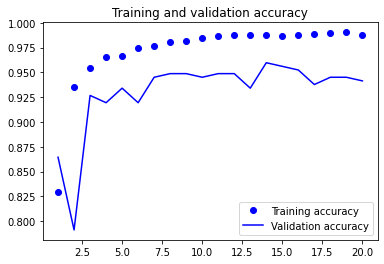

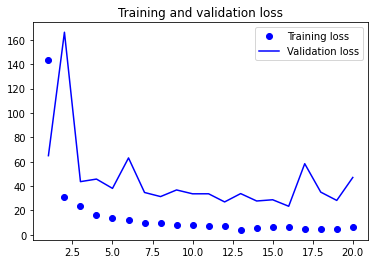


---- Test ----

18/18 [==============================] - 60s 3s/step - loss: 26.7768 - accuracy: 0.9693
Test accuracy: 0.969


In [ ]:
if Train_VGG16:
  print("\n---- Training & testing of VGG16 model for three painters ----\n")
  filename = "4P_VGG16"
  P4_VGG16_model_DA = construct_VGG16_DA_model()
  print("\n---- Training ----\n")
  history = start_training(P4_VGG16_model_DA, filename, epochs=TVGG16_epochs)
  print("\n---- Results ----\n")
  plot_results(history)
  print("\n---- Test ----\n")
  test_model(filename)
else:
  print("\n---- Training & testing of VGG16 model for two painters skipped ----\n")

In [ ]:
model = keras.models.load_model("4P_VGG16"+".keras")
model.save("DefinitiveModel.h5")